# A practical guide to time series - Store sales
Today we are going to talk about time series and forecasting! Forecasting is the use of a predictive model to predict future values based on previously observed values and meaningful characteristics of the time series data. It has application in various industries and use cases such as finance, retail, marketing and even anomaly detection for system outage.

## 1. Importing Libraries and dataset
We'll talk about individual libraries down the road as it's not obvious how they are helpful at this point of time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import numpy as np
from pmdarima import auto_arima
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

from tsfresh.utilities.dataframe_functions import impute
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller

from random import seed
from random import random
from sklearn.metrics import mean_squared_error
from statsmodels.graphics import tsaplots
from tbats import BATS, TBATS
from tsfresh import extract_features

from pmdarima.arima import auto_arima

//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
plt.style.use('fivethirtyeight')

We'll use a small dataset, the Superstore sales data that can be downloaded from here.

In [3]:
df = pd.read_excel('Sample - Superstore.xls')

Each row represents a sales transaction with pretty rich information such as customer demographics and profit. These would be helpful for feature engineering if we are going down the machine learning approach. 

In [4]:
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


There are tons of products with different categories over here. For now, let's just look at "Furniture".

In [5]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [6]:
sales_df = df.loc[df['Category'] == 'Furniture']

A quick look at the available period of the time series.

In [7]:
sales_df['Order Date'].min(), sales_df['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have 4 years of data to play with!

## 2. Data preprocessing
Let's transform the data to univariate time series data by using only the main variable that we are most interssted in: sales. When we model univariate time series, we are modeling time series changes in a single variable over time.

As a side benefit, we don't need to check and clean the data for all features. So let's just check for empty values for this particular variable.

In [8]:
sales_df = sales_df[['Order Date','Sales']]
sales_df = sales_df.sort_values('Order Date')

In [9]:
sales_df.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [10]:
sales_df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

We are very lucky that this is a clean dataset; no empty value 😂

Recall that each row of the dataset is a sales transaction so there will be multiple sales for each date(day). We want to summarize the data into a sales per day format. We are using summation to summarize, you could use other statistics as well.

In [11]:
#the reset_index is here is to regenerate the index on the grouped panda series
sales_df = sales_df.groupby('Order Date')['Sales'].sum().reset_index()

## 3. Data Wrangling
We are going to make the order date as the index so that moving forward, the data manipulation can be easier.

In [12]:
sales_df = sales_df.set_index('Order Date')
sales_df.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


### 3.1 Unevenly space  time series
Notice that there are missing values for 8th, 9th and 12th in the time series data.

We have met our first problem, the infamous "unevenly space time series" problem that is well studied in the field.

1) If your eventual output allows you to forecast at monthly level, you are in luck: you could just resample at a higher level(roll up days to month and aggregate the values). There's a handly function to do it quickly: DataFrame.resample

2) Interpolate the data 

#### Naive way: Downsample to monthly frequency

In [13]:
monthly_sales_df = sales_df.resample('MS').mean()

In [14]:
monthly_sales_df.head()

,Sales
Order Date,
2014-01-01,480.194231
2014-02-01,367.931600
2014-03-01,857.291529
2014-04-01,567.488357
2014-05-01,432.049188


We'll talk about interpolation of time series later...

## 4. Visualizing the time series
Just like our usual data analysis work, we first plot the data before any modelling work(if any), in an attempt to identify some distinguishable patterns.

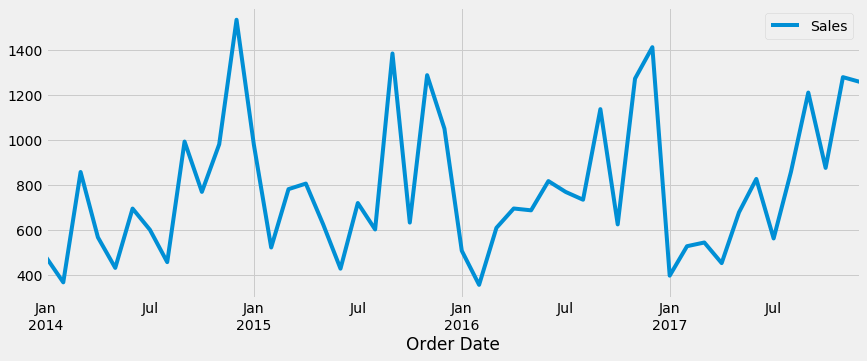

In [15]:
monthly_sales_df.plot(figsize=(13, 5))
plt.show()

### 4.1 Describing Patterns - Seasonality

The first obvious pattern we observe in the plot is the yearly seasonality(12 months=a cycle). Sales are relatively lower at the start of the year and end higher at the end of the year, and this pattern repeats itself every year. The sales are also trending slightly downwards over the years.

A time series process could be decomposed into several components: 
Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.

Instead of guesstimating the components, We could use scipy's seasonal_decompose function automatically decompose a time series and plot it out to have a better inspection of each component.

Note that there's a model parameter, which means whether the time series is an additive and multiplicative model. The difference is how the compoenents are being combined together.

Additive Model = y(t) = Level + Trend + Seasonality + Noise

Multiplicative Model = y(t) = Level * Trend * Seasonality * Noise

A easy rule of thumb: If you observe increasing variance over time, it's likely to be Multiplicative.

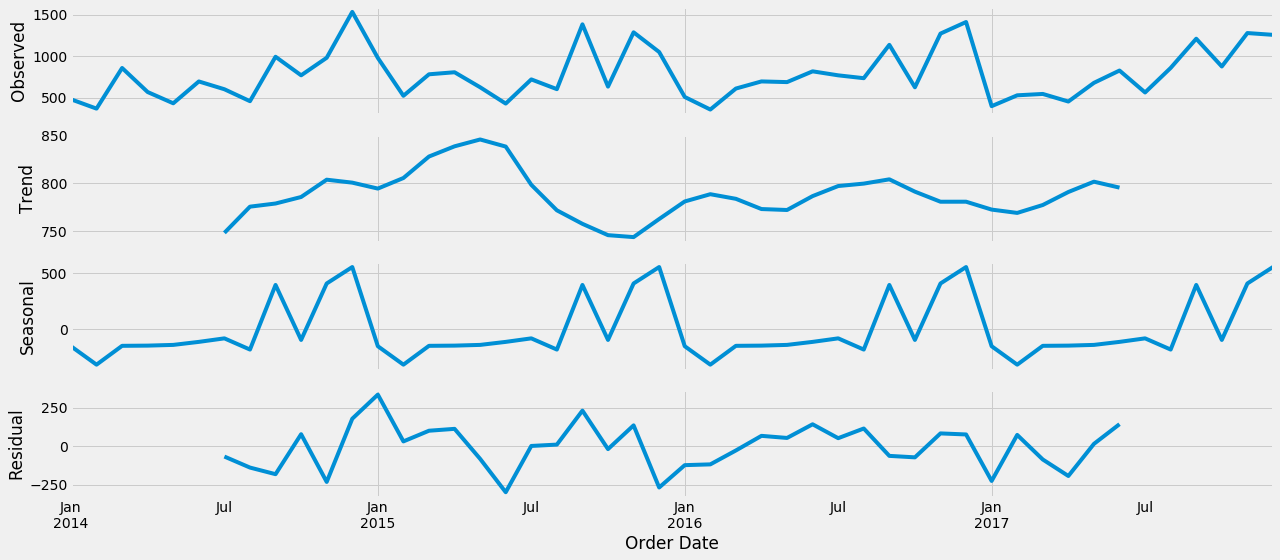

In [16]:
rcParams['figure.figsize'] = 18, 8
# note that the freq defaults to freq of dataframe's
decomposition = sm.tsa.seasonal_decompose(monthly_sales_df, model='additive')
fig = decomposition.plot()
plt.show()

We could see the yearly seasonality more obviously in the seasonal component and the trend is heading downwards just like what we have observed.

### 4.2 Describing Patterns - Stationary
We could describe the time series as a stationary or non-stationary process as well. This is an important concept in time series and is rooted in several time series models' assumptions so let's take a quick look at it.

The definition can get a bit hairy and there are 2 forms of stationary: weak-form and strict stationary. 

#### 4.2.1 "Weak-form" or "Covariance" stationary:
<img src='ts_pics/cov_stat.png' width=500>
1) Constant mean
2) Constant variance 
3) Same covariance between periods of the same length.

#### 4.2.2 "Strict" stationary:
<img src='ts_pics/cov_stat2.png' width=500>
Strict stationary is more restrictive as it requires the same distribution between 2 periods of the same length. In practice, we often refer to the weak-form stationary as the strict variant is rarely observed.

#### 4.2.3 Other observable traits of stationary:
1) The observations in a stationary time series are not dependent on time.

2) They don't have trend or seasonal effect

#### 4.2.4 Visual Example of stationary
The concept of stationary can be a little slippery, sometimes it's helpful to look at the plot visually. To nail it down, a stationary time series could look like this plot:
<img src='ts_pics/stat_eg.png' width=500>
Notice that the magnitude and mean values don't change over time. The values don't increase over time(trend), the values are not corelated with time, and there's no seasonality patterns like our store sales.



#### 4.2.5 Why do we care about stationary?
1) Stability; A stationary time series has stable statistical properties over time.

2) Statistical modeling methods such as ARIMA(we will come to that later) assume or require the time series to be stationary to be effective.

3) We are interested in modelling the relative difference between timesteps rather than the absolute values. For example: We want the model to learn the % of increase or loss following a pattern rather than learning the value at $1,200 at a certain time.

#### 4.2.6 How do we make our time series stationary?
1. A log transformation or square root transformation are two popular options, particularly in the case of changing variance over time.

2. The most popular option when we have time series data exhihiting trend is differencing. We could difference(intergration) by subtracting $Y_{t-1}$ from $Y_t$ of our time series to make it stationary. Recall our time series plot from above:

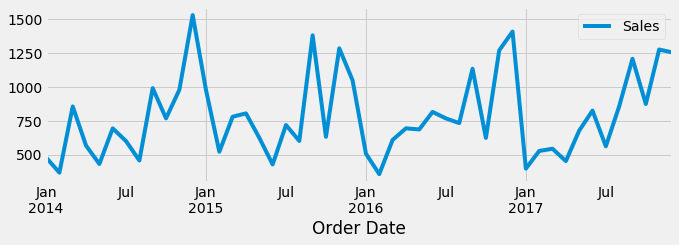

In [17]:
monthly_sales_df.plot(figsize=(10, 3))
plt.show()

We could use Panda's diff() to quickly perform differencing.

In [20]:
diff_monthly_sales_df = monthly_sales_df.diff()

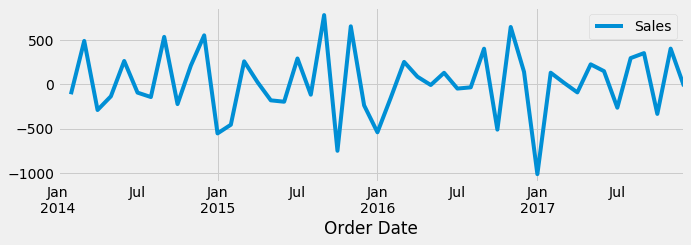

In [21]:
diff_monthly_sales_df.plot(figsize=(10, 3))
plt.show()

#### 4.2.7 Testing for stationality
To test for stationality, we could use a statistical test, the Augmented Dickey-Fuller(ADF) test where the null hypothesis of the test is that the time series is not stationary (has some time-dependent structure). The alternate hypothesis is that the time series is stationary. In other words, if your time series is truly stationary, you should get a p-value of <=0.05 (95% confidence interval, significance level(α) of 0.05) which suggets us to reject the null hypothesis.

Here's an example using the statsmodels library.

The first line is the test statistic which we could use to compare against certain critical value in the Dicker-Fuller table to determine statitical significant.

Conveniently, it also provide us the critical values of several common levels of significance(1, 5 and 10%), from the DF table.

In this case, we could see that the test statistic is smaller than not just 5% but also all levels of signifcant. Therefore, we can confidently reject the null hypothesis and <b>say that this time series is stationary.</b>

Alternatively, we could simply use the p-value associated with the test statistic, on the second line. This can be pretty handy as you could just quickly compare against the 1%(0.01), 5%(0.05) or 10%(0.10) confidence level to determine statitical significant.

The third line(10) refers to the number of lags and we could say that there are some auto-correlation going back for 10 periods.

Finallt, the fourth line(37) simply expresses the number of observations.



In [24]:
adfuller(monthly_sales_df.Sales.values)

(-5.19107018733927,
 9.168756655665654e-06,
 10,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 521.9616303121272)

### 4.3 Describing patterns - White noise

A related topic of stationary is "White noise", which is a type of time series that the data doesn't follow a pattern. And if we cannot take advantage of the pattern in the past to infer the same for the future, then it cannot be predicted! Therefore, it's good to check for white noise pattern before we even consider modelling.

How do we spot white noise? <b>These are the definition:</b>

1) Constant mean($\mu$) of 0

2) Constant variance($\sigma^2$)

3) No(zero) autocorrelation (No relationship between past and present values)

Have mean zero, and a finite variance: 
$$E(X(t)) = 0, E(X(t)^2) = S^2\text{, and } E(X(t)X(h)) = 0 \text{ for } t\neq h\text{.}$$

We will get to autocorrelation soon but it's basically the amount of correlation between a time series and a past version of itself. 

#### 4.3.1 Visual example of white noise
Again, to nail it down, a white noise looks like this in a plot.

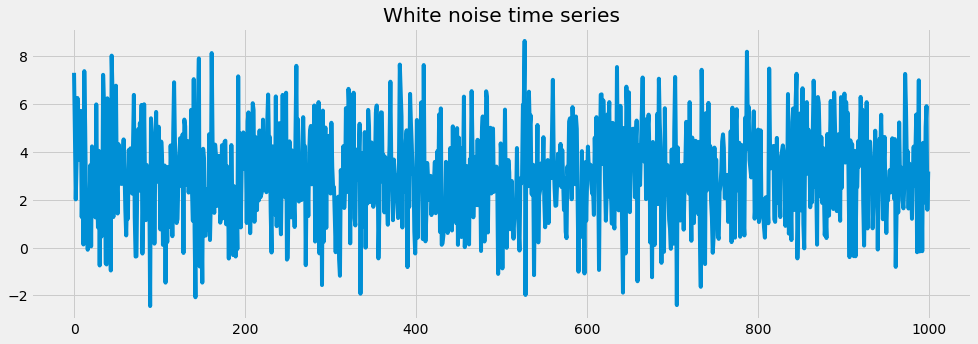

In [25]:
rcParams['figure.figsize'] = 15, 5
random_white_noise = np.random.normal(loc=3, scale=2, size=1000)
plt.plot(random_white_noise)
plt.title('White noise time series')
plt.show()

We could see the values are normally distribiuted around the mean of 3 (most values forming around 3) and the magnitude mostly staying within 2 units.

Most importantly, it appears to behaves sporadically; there's zero correlation between past and future values, so there's no way that we could use the past patterns to project the future values.

#### 4.3.2 Why do we care about white noise?

1) If your time series is white noise, <b>it cannot be modelled.</b>

2) The residuals of a time series model should be white noise. That means that all of the signals in the time series has been harnessed by the model in order to make predictions. All that is left is the random fluctuations that cannot be modeled.

#### 4.3.3 White noise VS Stationary

If you were thinking that white noise sounds like the stationary that just went through, you are right! Note that while a white noise time series is stationary, not every stationary time series is white noise.

#### 4.3.4 Modelling white noise
One of the things that confused me when I started learning these concepts is that stationary is a prequistite for modelling a particular time series but if white noise is also stationary, why can't we model the white noise?

To be precise, what I was thinking: White noise = Stationary = Okay to Model?

Here's a way to think of it: Remember that we difference the orginal time series to make it stationary. This act of differncing is effectively a way to eliminating/reducing the trend and seasonality, in an attempt to stablize the mean of the time series. We might difference it multiple times(orders) until all temporal dependence has been removed. 

If there's no signal left, the number of orders could actually be used to model the time series with a linear trend and seasonality.

If there's some signal left, it's probably still largely stationary and the remaining signals might have some autocorrelation. We could then move on to model this autocorrelation signals. 

We will see a clearer picture as we go through a end-to-end example later.

### 4.4 Describing Pattern - Random Walk
The last important time series pattern we want to talk about is the "Random Walk", which is a special type of time series where values tend to presist over time and the differences between periods are simply white noise(random).
In other words, the prices of today is equals to prices of yesterday and some residuals of white noise
$$P_t = P_{t-1} + \epsilon $$

where $\epsilon \sim WN(\mu,\sigma^2)$
 
#### 4.4.1 Visual example of random walk

In [26]:
rand_walk = pd.read_csv('RandWalk.csv')
rand_walk['date'] = pd.to_datetime(rand_walk['date'],dayfirst=True)
rand_walk.set_index('date',inplace=True)
rand_walk = rand_walk.asfreq('b') # convert/sample freq to business days(b)

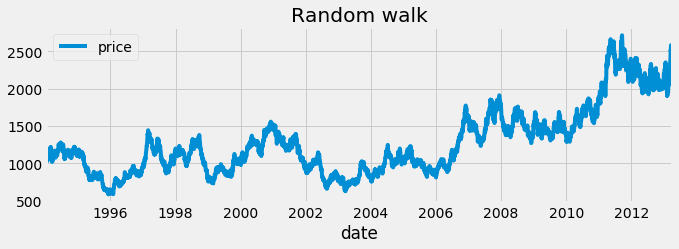

In [27]:
rand_walk.plot(figsize=(10,3))
plt.title('Random walk')
plt.show()

We could see that it's very different from the white noise we just talked about. In fact it looks like a series of stock or index prices where it exhibits some patterns. This is because the series itself is not random, although the differences are random.

The random walk has it's root in finance, and is base on a financial theory that stock market prices are a random walk and cannot be predicted. However it's worth mentioning that this <a href='https://en.wikipedia.org/wiki/Random_walk_hypothesis'>claim is arguable.</a>

Going back to the definition: we could definietly see small variations between consecutive time periods or in other words, values at $P_t$ depends on $P_{t-1}$

To avoid some confusion that I had when I started learning the concepts we went through, here are some differences.

#### 4.4.2 Random walk vs stationary
Random walk is a non-stationary process as we could see that it greatly violates the assumption of stationary. A stationary time series is one where the values are not a function of time. On the other hand, the observations in a random walk are dependent on time.

#### 4.4.3 Random walk vs White noise
Not the same; white noise is like a sequence of random numbers. While the random walk values can appear random, the next value($P_{t+1}$) is always a modification of the previous value($P_t$) in the sequence. There is a underlying process that generates some consistency from step-to-step rather than spitting out random numbers. This is why random walk is also called a "drunkard’s walk".

#### 4.4.4 Why do we care about Random walk?
If you have a random walk time series, <b>then it cannot be skillfully predicted.</b> This is simply because the next time step is a function of the prior time step and such model provide naive forecast. We call such models as "persistence model".

Let's do a small experiment where we generate a time series of random walk and split the dataset into train and test sets.

In [82]:
# generate the random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    #add -1 or 1 to prev value
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]
len(train), len(test)

(660, 340)

In [90]:
random_walk_series = pd.Series(train+test, index = range(1000))#index=list(range(len(train)))+list(range(len(test))))

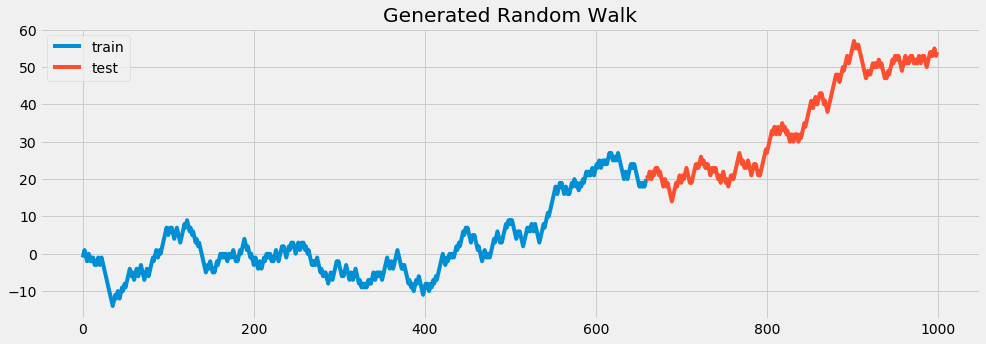

In [99]:
plt.plot(random_walk_series[:660],label='train')
plt.plot(random_walk_series[660:],label='test')
plt.title('Generated Random Walk')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

We use the persistence model to predict the outcome using a rolling forecast method and we calculate the MSE for all predictions are collected from the test set.

In [30]:
# persistence
predictions = list()
history = train[-1]
#loop thru each step and take last observation as prediction for current step..
for i in range(len(test)):
    yhat = history
    predictions.append(yhat)
    history = test[i]
error = mean_squared_error(test, predictions)
print('Persistence MSE: %.3f' % error)

Persistence MSE: 1.000


Obviously, since the observations are constructed by generating either -1 or +1 of the previous values, calculating the MSE of "predictions" would also be 1. 

But what happens if we say that we know the variance of the process, then we can sprinkle a little variance when generating the values?

In [31]:
seed(1)
predictions = list()
history = train[-1]

for i in range(len(test)):
    yhat = history + (-1 if random() < 0.5 else 1)
    predictions.append(yhat)
    history = test[i]
error = mean_squared_error(test, predictions)
print('Random MSE: %.3f' % error)

Random MSE: 1.976


It ended up with even worse performance. We can conduct more experiments later, with more complex model if that doesn't convince you. So where does it go from here? There are 2 takeaways:

1) The best model/predictor for a random walk is at most a persistence model. 

2) A persistence model could be a baseline model before you employ fancy time series modelling techniques. If the performance(skill) of your final model cannot beat a persistence model, it also means we are better off with just taking the previous value as a prediction. Ouch!

#### 4.4.5 How to tackle a suspected random walk time series?
Granted that most time series out there are random walks, we could <b>try</b> to model the first order differences instead of the raw values. Remember in the stationary section where we talk about differencing the time series to make it stationary before we begin modelling. However, if making it stationary still shows no obviously learnable structure in the data, then it cannot be forecasted.

## 5. Modelling - ARIMA model
Finally, with some of the important concepts out of the way, we can start to look at modelling time series!

ARIMA and it's variants(ARMA, ARMAX, SARIMA) is the classic model for almost all time series literature. ARIMA is a traditional time series model that models the Autoregressive(AR) and Moving Average (MA) nature of the time series. For time series with seasonality, like the one we talked about above, we could use the Seasonal ARIMA (SARIMA) to model such process. Let's look at the building blocks and assumptions of the simpliest ARMA model.

### 5.1 Autoregressive(AR)

In time series, there's often a relationship between past and present values. For example, we could do a reasonable guess of the sales today given yesterday's sales, or maybe the sales 7 days ago. Therefore, we use  <b>Autocorrelation</b> which is the correlation between a sequence of itself.
<img src='ts_pics/autocorr1.jpg' width=500>
<img src='ts_pics/autocorr2.jpg' width=500>
For example, the above picture illustrates the corelation between the current series and a lagged version of itself (t-1, lag of 1). The frequency of lagged values could be in days, weeks or months.

ARIMA takes advantage and model this AR nature of a time series. We could picture this as a linear model that relies on a sum of past period values multiplied by a constant(coefficient) to predict the current period values.
<img src='ts_pics/ar_model.png' width=500>

It's likely that the more lagged values(lags) we use in a ARIMA model, it could model more complex relationships and interactions. Hence, we often not only use lagged values of 1: AR(1), but also further lagged values: AR(2), AR(3), etc.
<img src='ts_pics/ar_model2.png' width=500>

However, when we include more coefficients, it's more likely that some of them are not significant(different from zero) and just like any machine learning or Neural network models, more parameters might lead to overfitting. 

#### Auto-correlation Functions (ACF)
We could imagine that it's extremely helpful to calculate the auto correlation of different lags simultaneously:

$$\rho(k) = \frac{\frac{1}{n-k}\sum_{t=k+1}^n (y_t - \bar{y})(y_{t-k} - \bar{y})}{
\sqrt{\frac{1}{n}\sum_{t=1}^n (y_t - \bar{y})^2}\sqrt{\frac{1}{n-k}\sum_{t=k+1}^n (y_{t-k} - \bar{y})^2}} \,,$$

The top portion is essentially the covariance between the original data and the k-unit lagged data.  The bottom is sum of the squared deviations of the original data set. 

And this is the main idea behind the ACF. We could calculate it manually or we could simply just use the plot_acf() function from statsmodels library.

[]

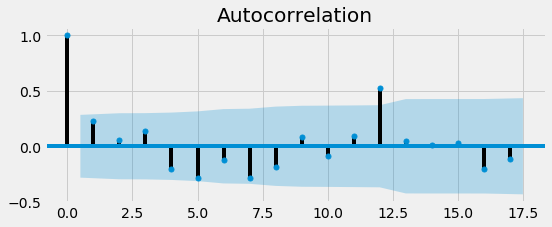

In [106]:
rcParams['figure.figsize'] = 8, 3
tsaplots.plot_acf(monthly_sales_df.Sales.values, zero=True)
plt.plot()

Obviously, we could see that the time series has the highest correlation with its lagged value at 0(lag=0, basically itself). What is more interesting is that we could see a significant correlation at a lag of 12. This makes perfect sense and it's a good indication of seasonality; this month's sales is highly correlated with 12 months ago.

ACF and the closely related PACF plots are deeply rooted concepts in traditional time series analysis and they could taught for half day in a formal class so we'll skip this for now...

### 5.2 Moving Average (MA)

There's a problem with a AR model; Since present values relies on past values, an unpredictable sudden increase in value(shocks) couldn't be reliably predicted. One idea is to introduce an additional component(MA) which takes into account past residuals to auto-correct and make adjustments to the predictions. Mathematically, it looks like this:

<img src='ts_pics/ar_model3.png' width=500>



The same set of components(AR and MA) could be applied to the seasonality too, with an additional term.



### 5.3 Integration (I)
This refer to the number of times we need to integrate(difference) the time series to ensure stationarity which ARIMA assumes.

Recall that if you have a non-stationary time series at hand, we could transform the time series into a stationary process by differencing so that it fits the assumption.

In finance, one common approach is to simply use returns, which is the % change between the values of 2 consecutive periods, instead of prices. In pandas, we could simply use the "pct_change()" function to accomplish that.

#### Notation
We often express ARIMA model with the p,d,q parameters which refers to the order of AR, I, and MA respectively. Moving forward, we will use this notation.

All these concepts might sound abstract but it will make sense after we start to fit a time series to a ARIMA model. The very last thing that we have to touch on before we begin modelling, is how we should go about evaluating the model.

## 6. Model selection and data leakage
While the model selection strategy is similar to general modelling where you split the dataset into train and validation/test, and fit model on train while selecting the model based on its performance of validation split, it's more tricky with time series.

This is because we need to make sure we are not leaking information from the future into the past. This could sneakily happen in common preprocessing techniques such as expoenential smoothing. When dealing with time series, it would be a mistake to randomly split the data into train and test sets using the usual(train_test_split from Scikit-Learn). That would lead to, for example, making predictions about 2014 using data from 2015.

A simple solution is to split the time series data into 2 windows of date range. For example, we could use the time series from 1/2014 to 12/2016 for training and 2017 for validation.

If you are a big fan of cross-validation (CV) methods, you could roll forward training, validation and testing windows that makes use of all data at once:
<img src='ts_pics/roll1.png' width=500>

Alternatively, you could also move the training window rather than expanding it which would look like this:
<img src='ts_pics/train_split.png' width=500>

For simplicity, we'll just split the data using the simple solution in this notebook.

TODO: Talk about the rolling CV...

## 7. Fitting a ARIMA model efficiently
The traditional way is to increase the coefficient sequentially, look at the statistical signifacnt of the coefficients, compare the log likelihood and stop increasing when the model fails to improve. A more efficient way is to use <b>AutoARIMA</b> or a couple of nested loops(<b>Grid Search</b>) to find the optimal set of parameters that yields the best Akaike's Information Criterion(AIC) for our model.

The AIC of a model is equal to AIC = 2k – 2lnL where k is the number of parameters of the model and L is the maximum likelihood value for that function. In general, we want to lessen the complexity of the model (i.e., lessen k) while increasing the likelihood/goodness-of-fit of the model (i.e., L). So we will favor models with smaller AIC values over those with greater AIC values.

In [40]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Remember that we had the luxury of 4 years of data? We could seperate first 3 years worth of them to be the "training data" and the last 1 year to be the "validation set".

In [41]:
train_monthly_sales_df = monthly_sales_df[:-12]
valid_monthly_sales_df = monthly_sales_df[-12:]

Just to make sure there's no data leakage...

In [42]:
train_monthly_sales_df.tail(3)

,Sales
Order Date,
2016-10-01,624.872474
2016-11-01,1271.345152
2016-12-01,1410.719808


In [43]:
valid_monthly_sales_df.head(3)

,Sales
Order Date,
2017-01-01,397.602133
2017-02-01,528.179800
2017-03-01,544.672240


### 7.1 GridSearch 
Running the GridSearch using the good ol' loops.

In [38]:
bestAIC = np.inf
bestModel = None
for param in pdq:
    print('param:',param)
    try:
        mod = sm.tsa.statespace.SARIMAX(train_monthly_sales_df,
                                        order=param,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False,
                                       trend='c')
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        if results.aic < bestAIC:
            bestAIC = results.aic
            bestModel = results
            print('****BEST****')
    except:
        continue


param: (0, 0, 0)
ARIMA(0, 0, 0) - AIC:503.4335944371523
****BEST****
param: (0, 0, 1)
ARIMA(0, 0, 1) - AIC:488.8972633551307
****BEST****
param: (0, 0, 2)
ARIMA(0, 0, 2) - AIC:477.4721439070175
****BEST****
param: (0, 1, 0)
ARIMA(0, 1, 0) - AIC:503.4250970460873
param: (0, 1, 1)
ARIMA(0, 1, 1) - AIC:477.74578597733233
param: (0, 1, 2)
ARIMA(0, 1, 2) - AIC:465.12985166740384
****BEST****
param: (0, 2, 0)
ARIMA(0, 2, 0) - AIC:524.1351010222072
param: (0, 2, 1)
ARIMA(0, 2, 1) - AIC:478.17920833300695
param: (0, 2, 2)
ARIMA(0, 2, 2) - AIC:457.24955345064654
****BEST****
param: (1, 0, 0)
ARIMA(1, 0, 0) - AIC:503.6859140970196
param: (1, 0, 1)
ARIMA(1, 0, 1) - AIC:490.9888150754283
param: (1, 0, 2)
ARIMA(1, 0, 2) - AIC:479.4712148668157
param: (1, 1, 0)
ARIMA(1, 1, 0) - AIC:497.5089291893447
param: (1, 1, 1)
ARIMA(1, 1, 1) - AIC:478.63613140108936
param: (1, 1, 2)
ARIMA(1, 1, 2) - AIC:467.1294818542604
param: (1, 2, 0)
ARIMA(1, 2, 0) - AIC:506.6294753582548
param: (1, 2, 1)
ARIMA(1, 2, 1) - 

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2) - AIC:459.213961399202
param: (2, 0, 0)
ARIMA(2, 0, 0) - AIC:490.77583016301736
param: (2, 0, 1)
ARIMA(2, 0, 1) - AIC:492.8970451694744
param: (2, 0, 2)
ARIMA(2, 0, 2) - AIC:483.38750079889166
param: (2, 1, 0)
ARIMA(2, 1, 0) - AIC:481.4665623346183
param: (2, 1, 1)
ARIMA(2, 1, 1) - AIC:483.4594258013412
param: (2, 1, 2)
ARIMA(2, 1, 2) - AIC:472.0229894684058
param: (2, 2, 0)
ARIMA(2, 2, 0) - AIC:482.2859114270986
param: (2, 2, 1)
ARIMA(2, 2, 1) - AIC:473.1825692321964
param: (2, 2, 2)
ARIMA(2, 2, 2) - AIC:460.7219115408243


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [39]:
bestModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -224.625
Date:                Thu, 02 Jan 2020   AIC                            457.250
Time:                        12:21:25   BIC                            462.986
Sample:                    01-01-2014   HQIC                           459.119
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9168      2.503      0.366      0.714      -3.989       5.822
ma.L1         -1.6232      0.315     -5.152      0.000      -2.241      -1.006
ma.L2          0.6232      0.243      2.570      0.010       0.148       1.098
sigma2      1.029e+05   4.48e-06    2.3e+10      0.000    1.03e+05    1.03e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.28
Prob(Q):                               nan   Prob(JB):                         0.87
Heteroskedasticity (H):               0.51   Skew:                             0.14
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+27. Standard errors may be unstable.
"""

The GridSearch method reveals that <b>ARIMA(0,2,2)</b> has the lowest AIC and hence the best model!

### 7.2 AutoARIMA
AutoARIMA is a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC. The orginal package is in R but fortunatly it's now availble in Python, in the pmdarima library.

The auto.arima() function will do the differencing before estimation to ensure consistent estimators. The estimation of the regression coefficients and ARIMA model is done simultaneously using MLE.


Recall that ARIMA assumes stationality, so we will use that time series that we have differenced our time series by a order of 1. The first value is NA so we should start from the second index.

In [44]:
auto_model = auto_arima(train_monthly_sales_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=503.640, BIC=509.746, Fit time=0.070 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=539.784, BIC=542.836, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=521.895, BIC=526.474, Fit time=0.008 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=508.765, BIC=513.344, Fit time=0.028 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=537.788, BIC=539.315, Fit time=0.005 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=503.211, BIC=510.843, Fit time=0.097 seconds
Near non-invertible roots for order (2, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 0)

The AutoARIMA determines that a ARIMA(0,2,2) model has the best results which collides with our Grid search method! Notice that the coefficients are extremely close, albeit not exact. 

In [45]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -246.704
Date:                Thu, 02 Jan 2020   AIC                            501.408
Time:                        12:27:30   BIC                            507.513
Sample:                             0   HQIC                           503.490
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6247      5.088      0.123      0.902      -9.348      10.597
ma.L1         -1.6170     15.326     -0.106      0.916     -31.656      28.422
ma.L2          0.6178      9.379      0.066      0.947     -17.764      19.000
sigma2      1.008e+05   1.56e+06      0.065      0.948   -2.95e+06    3.16e+06
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.46
Prob(Q):                               nan   Prob(JB):                         0.80
Heteroskedasticity (H):               1.02   Skew:                             0.20
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 8. Validating model

We should plot out the model diagnostics to check if the model is valid.

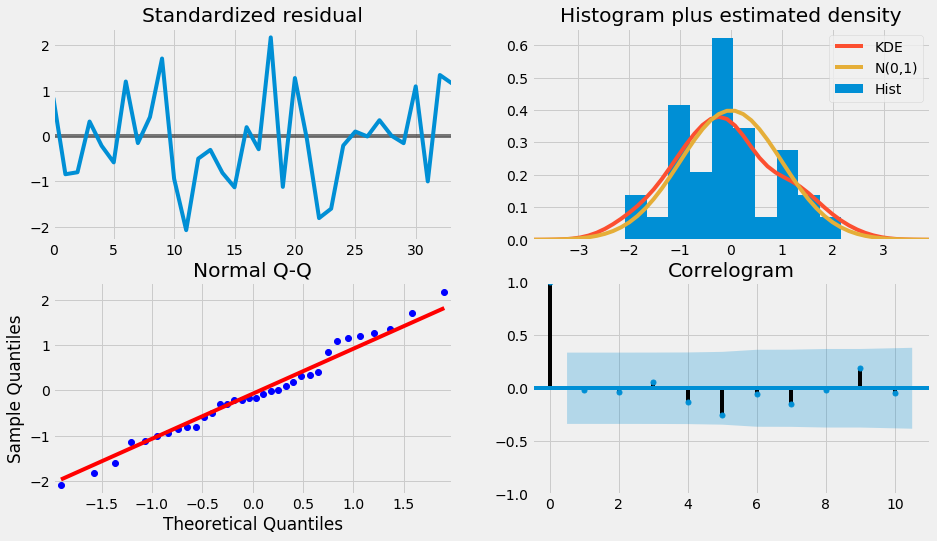

In [46]:
auto_model.plot_diagnostics(figsize=(14, 8))
plt.show()

It's a good sign that the residuals are near normally distributed(bottom left). Not perfect though; standardized residuals show that there's some signal that has yet to be modelled. The correlogram looks fine; the auto correlation is within bounds.
## 9. Forecasting with ARIMA
With the best model, let's try to predict the values for 1 year period and see how accurate it is.

Some technical note: We could use the get_prediction() and get_forecast() functions for prediction. One thing that intially confused me was the difference between them. Note that get_prediction() and get_forecast() are actually the same. The latter is designed to do 1-step out-of-sample forecast from the last available data, or perform multi-step out-of-sample forecast which is parameterized by "step" argument.

For example:
ts_model.forecast(steps=12)

It's more flexible with predict() where you just need to supply start and end date which could span across in-sample to out-sample. If you don't supply the end date, it will just do a in-sample forecast.

For example:
ts_model.get_prediction(start=pd.to_datetime('2014-01-01'), end=pd.to_datetime('2017-12-01'),dynamic=False)

### 9.1 Generating forecast

In [50]:
#autoarima
auto_oos_forecasts, auto_oos_forecasts_ci = auto_model.predict(n_periods = 12, return_conf_int=True)
#turn it into series so that we could plot easily...
auto_oos_forecasts = pd.Series(auto_oos_forecasts, index=valid_monthly_sales_df.index)

In [51]:
#gridsearch
#in-sample forecasts
#results = bestModel.fit()
is_forecasts = bestModel.get_prediction(start=pd.to_datetime('2014-01-01'),dynamic=False)
#out-of-sample forecasts
oos_forecasts = bestModel.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'),dynamic=False)

#forecasted values stored in is_forecasts.predicted_mean
#conf_int contains the confidence intervals
is_forecasts_ci = is_forecasts.conf_int()
oos_forecasts_ci = oos_forecasts.conf_int()

### 9.2 Visualizing forecast
Finally, we could see how the models' forecast fare against actual observed values. Since the model also provide 95% prediction interval, we also include them in the plot to have a better idea of the upper and lower bound values. For the sake of rigor, we'll show the forecast for both models selected via GridSearch method and AutoARIMA.

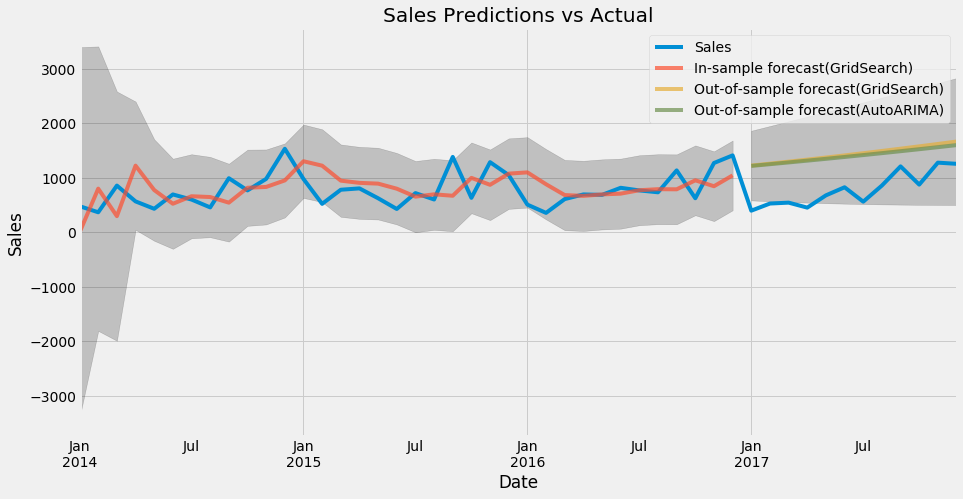

In [53]:
ax = monthly_sales_df.plot(label='observed')
is_forecasts.predicted_mean.plot(ax=ax, label='In-sample forecast(GridSearch)', alpha=.7, figsize=(14, 7))
oos_forecasts.predicted_mean.plot(ax=ax, label='Out-of-sample forecast(GridSearch)', alpha=.7, figsize=(14, 7))
auto_oos_forecasts.plot(ax=ax, label='Out-of-sample forecast(AutoARIMA)', alpha=.7, figsize=(14, 7))
ax.fill_between(is_forecasts_ci.index,
               is_forecasts_ci.iloc[:, 0],
               is_forecasts_ci.iloc[:, 1], color='k', alpha=.2)
ax.fill_between(oos_forecasts_ci.index,
               oos_forecasts_ci.iloc[:, 0],
               oos_forecasts_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Sales Predictions vs Actual')
plt.legend()
plt.show()

We have a couple of observations:

1) The models produced pretty decent in-sample forecasts(obviously) but the out-of-sample forecast appears like a constant line, although it's generally in the right direction.

2) As the forecast goes further, the prediction interval increases, demonstrating uncertainity. The prediction at each time steps exhibits some variation, and that variation accumlates as a function of the number of steps.

### 9.3 Quantitative evaluation
A quantitative way to assess the accuracy and compare models is to use metrics such as RMSE and MSE that basically measures the difference between the actual values and the predicted values.

In [57]:
y_forecasted = oos_forecasts.predicted_mean
y_truth = monthly_sales_df['2017-01-01':]
mse = ((y_forecasted - y_truth.iloc[:,0]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 454280.48
The Root Mean Squared Error of our forecasts is 674.0


It tells us that our model was able to forecast the average daily sales in the test set within 660.91 of the real sales. Since our daily sales range from around 400 to over 1200, the variance of error is considerable high and we might be even do a better job without the model. 

## 10. Seasonality - SARIMA
Notice that our plot above didn't take advantage of the seasonal pattern that we spotted earlier. It turns out that we could include a seasonal(S) component to the ARIMA model, by repeating the same AR, MA, I component for a seasonal cycle and we call it <b>SARIMA</b>.

For example, we want to capture the previous festive period(12 months ago), we could include add a phi(𝜙) parameter and a seasonal term that hold that value, or even 2 periods(24) back. This is actually very similar to the original AR term which holds value a month back.
<img src='ts_pics/seasonal.png' width=500>

At the same time, we also add an additional parentheses containing the seasonal orders to the expressed in the notation:
SARIMA(p,d,q)(P,D,Q,s)

Seasonal AR, I, MA order is denoted by the uppercase variants and "s" refers to the length of cycle. If s=1, it means there's no seasonality. Assuming the frequency of time series is monthly, we could use s=12 for yearly seasonaality.

For example, if we have:
SARIMA(1,0,2)(2,0,1,12)

What it means: Ignoring the first parentheses, the first 3 orders of the 2nd parentheses are simply the seasonal variations of the ARIMA orders. We are including the lagged values from 12 and 24 periods ago. Intuitively, we are interested in every "s"-th value.

Formally, it looks like this:
<img src='ts_pics/sarima.png' width=500>

### 10.1 AutoARIMA-Seasonal
We use the same method as above except for a few parameter changes to activate the search in the seasonal parameter space.

In [58]:
auto_sea_model = auto_arima(train_monthly_sales_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=344.604, BIC=346.786, Fit time=0.006 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=329.207, BIC=333.571, Fit time=0.113 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=342.680, BIC=343.771, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=331.805, BIC=335.078, Fit time=0.026 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


In [59]:
auto_sea_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(2, 2, 1)x(1, 1, 0, 12)   Log Likelihood                -154.970
Date:                            Thu, 02 Jan 2020   AIC                            321.940
Time:                                    12:31:40   BIC                            328.486
Sample:                                         0   HQIC                           323.482
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.1748     22.137      0.189      0.850     -39.213      47.562
ar.L1         -0.5462      0.369     -1.481      0.139      -1.269       0.177
ar.L2         -0.1845      0.335     -0.552      0.581      -0.840       0.471
ma.L1         -0.9959     16.629     -0.060      0.952     -33.587      31.596
ar.S.L12      -0.7072      0.204     -3.460      0.001      -1.108      -0.307
sigma2      4.381e+04   7.28e+05      0.060      0.952   -1.38e+06    1.47e+06
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.31
Prob(Q):                               nan   Prob(JB):                         0.52
Heteroskedasticity (H):               0.42   Skew:                            -0.44
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
#autoarima
#technical note: the predict() for autoarima lib is different from statsmodel's arima
auto_sea_is_forecasts, auto_sea_is_forecasts_ci = auto_sea_model.predict_in_sample(return_conf_int=True)
auto_sea_is_forecasts = pd.Series(auto_sea_is_forecasts, index=train_monthly_sales_df.index)
auto_sea_is_forecasts_ci = pd.DataFrame(auto_sea_is_forecasts_ci,index=train_monthly_sales_df.index)


auto_sea_oos_forecasts, auto_sea_oos_forecasts_ci = auto_sea_model.predict(n_periods = 12, return_conf_int=True)
#turn it into series so that we could plot easily...
auto_sea_oos_forecasts = pd.Series(auto_sea_oos_forecasts, index=valid_monthly_sales_df.index)
auto_sea_oos_forecasts_ci = pd.DataFrame(auto_sea_oos_forecasts_ci,index=valid_monthly_sales_df.index)

### 10.2 Visualizing forecast

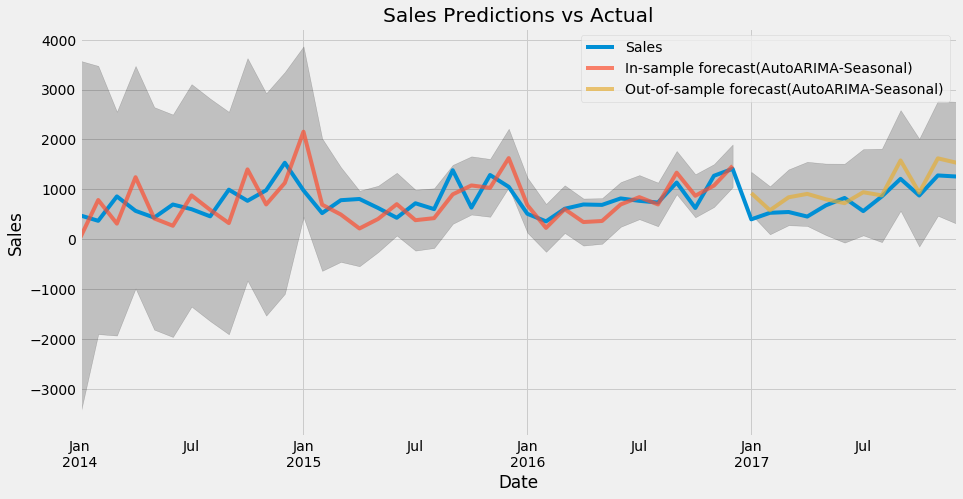

In [66]:
ax = monthly_sales_df.plot(label='observed')
auto_sea_is_forecasts.plot(ax=ax, label='In-sample forecast(AutoARIMA-Seasonal)', alpha=.7, figsize=(14, 7))
auto_sea_oos_forecasts.plot(ax=ax, label='Out-of-sample forecast(AutoARIMA-Seasonal)', alpha=.7, figsize=(14, 7))
ax.fill_between(auto_sea_is_forecasts_ci.index,
               auto_sea_is_forecasts_ci.iloc[:, 0],
               auto_sea_is_forecasts_ci.iloc[:, 1], color='k', alpha=.2)
ax.fill_between(auto_sea_oos_forecasts_ci.index,
               auto_sea_oos_forecasts_ci.iloc[:, 0],
               auto_sea_oos_forecasts_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Sales Predictions vs Actual')
plt.legend()
plt.show()

Compared to the previous attempt, a seasonal model has captured the seasonaliy really well, both for in-sample and out-of-sample forecasts.

### 10.3 Quantitative evaluation

In [67]:
y_forecasted = auto_sea_oos_forecasts.values
y_truth = monthly_sales_df['2017-01-01':]
mse = ((y_forecasted - y_truth.iloc[:,0]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 89577.16
The Root Mean Squared Error of our forecasts is 299.29


The RMSE has decresed to 303.21 compared to 674.0 above!